#PNEUMOVISION

Sistema de detección de neumonia por medio de IA
El análisis de imágenes médicas mediante redes neuronales para detectar patologías con alta precisión, en donde se podrá diferenciar entre una neumonía viral o bacteriana o de lo contrario no contar con dicha patología.



[DataSet KAGGlE](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)




In [ ]:
import os, glob, itertools, math, json, random
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics,callbacks,regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score
)

from collections import Counter

from PIL import Image, ImageStat, UnidentifiedImageError

import datetime

#ir agregando acá según las necesitemos

In [ ]:

IMG_SIZE, BATCH_SIZE, SEED = 224, 32, 42
AUTOTUNE = tf.data.AUTOTUNE

## DESCARGA DEL DATASET

In [ ]:
#SEBASTIAN
# Descargamos el Datase
data_set_xray = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", data_set_xray)



# definimos carpeta de entrenamiento
base_dir = os.path.join(data_set_xray, "chest_xray")
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")


# Carpetas de cada clase
normal_dir = os.path.join(train_dir, "NORMAL")
pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")


Path to dataset files: /kaggle/input/chest-xray-pneumonia


## Análisis y exploramiento de datos

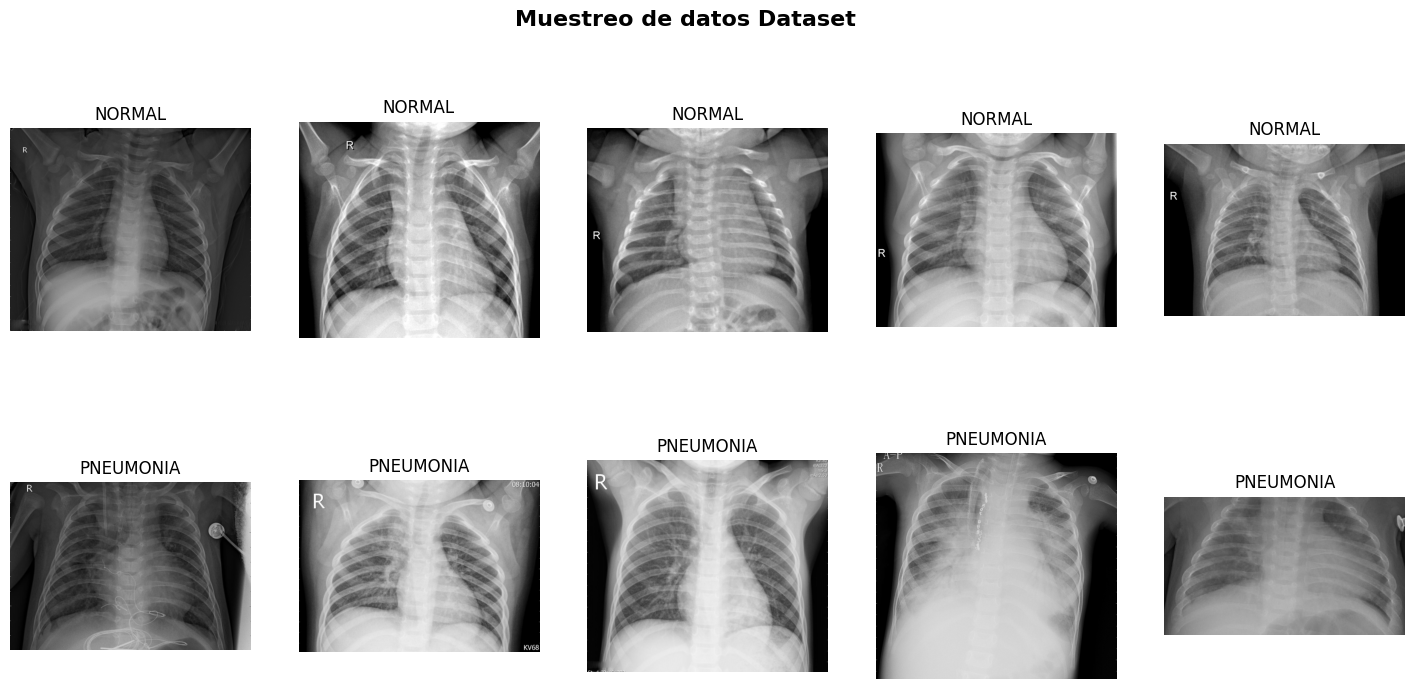

In [ ]:
#SEBASTIAN
#miramos 5 imágenes de cada libreria para verificar su calidad
normal_dir = os.path.join(train_dir, "NORMAL")
pneum_dir  = os.path.join(train_dir, "PNEUMONIA")

normal_images = glob.glob(os.path.join(normal_dir, "*.jpeg"))[:5]
pneumonia_images = glob.glob(os.path.join(pneum_dir, "*.jpeg"))[:5]

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle("Muestreo de datos Dataset", fontsize=16, fontweight="bold")

for i, images in enumerate(normal_images):
    axes[0, i].imshow(mpimg.imread(images), cmap="gray"); axes[0, i].set_title("NORMAL"); axes[0, i].axis("off")
for i, images in enumerate(pneumonia_images):
    axes[1, i].imshow(mpimg.imread(images), cmap="gray"); axes[1, i].set_title("PNEUMONIA"); axes[1, i].axis("off")
plt.show()


#Preprocesamiento de datos


In [ ]:
#SEBASTIAN
#realizamos el conteo de datos para evitar desbalanceos y preferencias de respuestas

def count_images(folder): return len(glob.glob(os.path.join(folder, "*.jpeg"))) #función que me retorna el número de archivos con formato .jpeg que hay en la carpeta
n_normal = count_images(os.path.join(train_dir, "NORMAL"))                      #datos en la carpeta NORMAL
n_pneum  = count_images(os.path.join(train_dir, "PNEUMONIA"))                   #datos en la carpeta PNEUMONIA
total    = n_normal + n_pneum

print( f"normal: {n_normal} -  pneum:{n_pneum} " )                                  #Muestra el total de datos para establecer si hay balanceo o no
                                                                                    #Muestra un claro desbalanceo de datos 1341 vs 3875

normal: 1341 -  pneum:3875 


#  Configuración de umbrales
Estos valores definen los criterios para "marcar" (flag) una imagen.
Los umbrales numéricos (brillo, varianza) están basados en el rango de 0 a 255 de los píxeles.Brillo: Verifica si la imagen es demasiado oscura (casi_negra) o sobreexpuesta (casi_blanca). Las imágenes con brillo extremo a menudo carecen de detalles útiles para el modelo.

Contraste y Variación: Analiza la varianza de los píxeles. Una varianza muy baja significa que la imagen es casi un solo color (baja_varianza), lo que la hace inútil para la mayoría de los modelos.

Tamaño: Revisa las dimensiones de la imagen. Si son menores que los valores mínimos que estableciste (muy_pequena), la imagen podría no contener suficiente información.

In [ ]:
#SARA
# --- UMBRALES DE CALIDAD DE IMÁGENES ---
BLACK_THRESHOLD_MEAN = 5       # Si el brillo promedio (0–255) es <= 5 → imagen muy oscura (casi negra).
WHITE_THRESHOLD_MEAN = 240     # Si el brillo promedio es >= 240 → imagen muy clara (casi blanca).
LOW_VARIANCE_THRESH = 5        # Si la varianza de los píxeles es <= 5 → imagen con muy poco contraste (plana, uniforme).
MIN_W, MIN_H = 100, 200        # Si ancho < 100 o alto < 200 → imagen demasiado pequeña para contener detalles útiles.


def scan_and_flag(folder):
    recs = []
    # Recorre el directorio de forma recursiva, incluyendo todos los subdirectorios.
    for root, _, files in os.walk(folder):
        for fname in files:
            # Ignora archivos que no sean imágenes en formatos comunes.
            if not fname.lower().endswith((".jpeg", ".jpg", ".png")):
                continue

            path = os.path.join(root, fname)

            # Diccionario que almacenará los datos y validaciones de la imagen.
            info = {
                "path": path,
                "class": os.path.basename(root), # La clase se asume como el nombre de la carpeta.
                "ok": True,                     # Se asume que la imagen es válida hasta comprobar lo contrario.
                "reason": [],                   # Se acumularán aquí las razones por las que se marca como inválida.
                "w": None, "h": None,           # Dimensiones de la imagen.
                "mean": None, "var": None       # Brillo promedio y varianza de la imagen.
            }

            try:
                with Image.open(path) as im:
                    w, h = im.size # Obtiene ancho y alto de la imagen.
                    info["w"], info["h"] = w, h

                    # Convierte la imagen a escala de grises (0=negro, 255=blanco).
                    # Esto simplifica el análisis de brillo y contraste al trabajar solo con un canal.
                    g = im.convert("L")

                    # Calculo estadístico de los píxeles (brillo y varianza).
                    st = ImageStat.Stat(g)
                    info["mean"] = st.mean[0] # Promedio del brillo de todos los píxeles.
                    info["var"] = st.var[0]   # Varianza: mide cuánta diferencia de brillo hay.

                    # --- CRITERIOS DE CALIDAD (flagging) ---
                    # Imagen demasiado oscura.
                    if info["mean"] <= BLACK_THRESHOLD_MEAN:
                        info["reason"].append("casi_negra")

                    # Imagen demasiado clara.
                    if info["mean"] >= WHITE_THRESHOLD_MEAN:
                        info["reason"].append("casi_blanca")

                    # Imagen con muy poco detalle (plana).
                    if info["var"] <= LOW_VARIANCE_THRESH:
                        info["reason"].append("baja_varianza")

                    # Imagen demasiado pequeña.
                    if (w < MIN_W) or (h < MIN_H):
                        info["reason"].append("muy_pequena")

            except (UnidentifiedImageError, OSError) as e:
                # Si no se puede abrir la imagen (formato incorrecto o archivo dañado),
                # se marca como ilegible.
                info["ok"] = False
                info["reason"].append(f"ilegible:{e}")

            # Se agrega la información de esta imagen al registro general.
            recs.append(info)

    return recs


def count_flags(recs):
    # Cuenta cuántas imágenes fueron marcadas con cada tipo de problema.
    c = Counter()
    for r in recs:
        # Si una imagen no tuvo ningún problema, se ignora.
        if not r["reason"]:
            continue
        # Acumula las razones encontradas en el contador.
        for tag in r["reason"]:
            c[tag] += 1

    return c


TRAIN flags: Counter({'muy_pequena': 32})
VAL   flags: Counter()
TEST  flags: Counter()
TRAIN - Casi negras: 0 encontradas. Mostrando 0.
TRAIN – Casi negras: 0 halladas.
TRAIN - Baja varianza: 0 encontradas. Mostrando 0.
TRAIN – Baja varianza: 0 halladas.
TRAIN - Muy pequeñas: 32 encontradas. Mostrando 12.


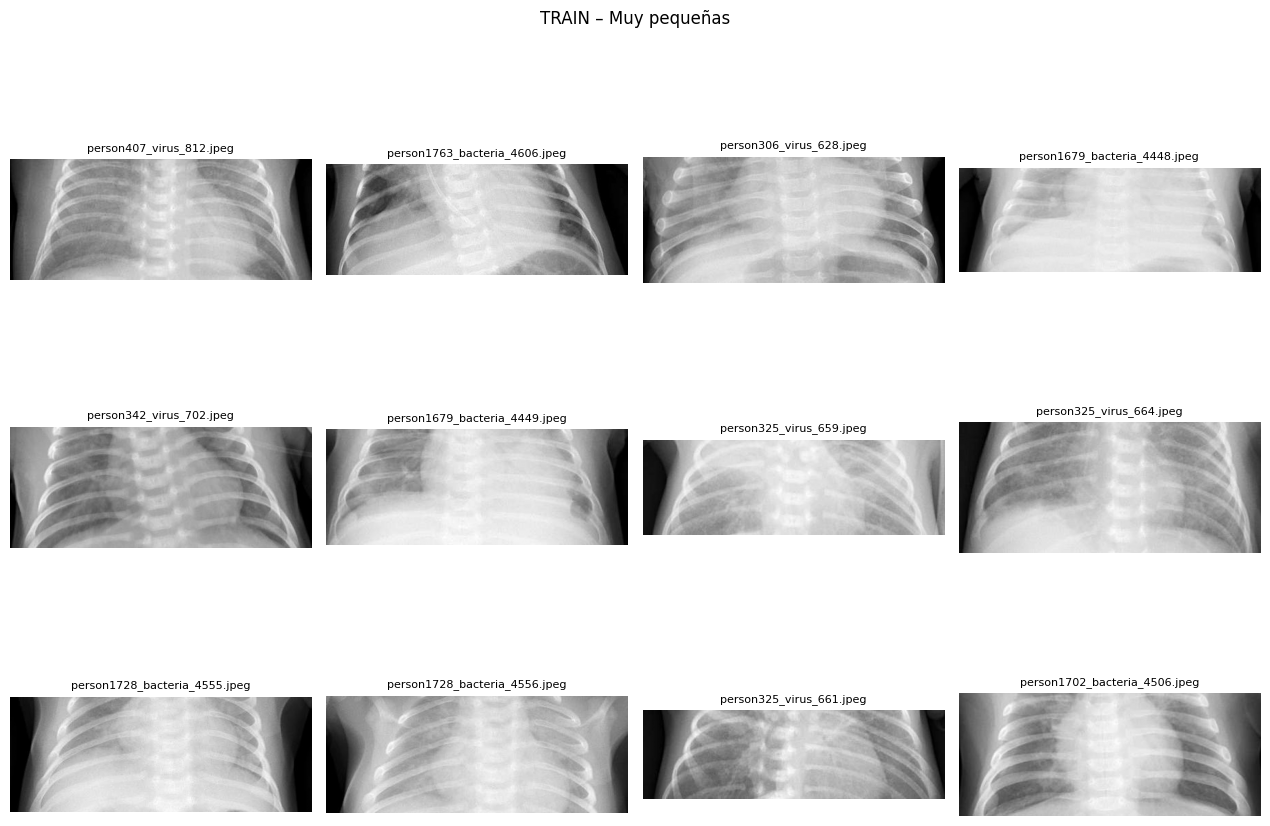

TRAIN – muy pequeñas por clase: {'PNEUMONIA': 32}
VAL   – muy pequeñas por clase: {}
TEST  – muy pequeñas por clase: {}


In [ ]:
#SARA
# --- Ejecución del escaneo y reporte ---
# Aquí se aplican las funciones a los conjuntos de datos: train, val y test.
# Cada carpeta se escanea con `scan_and_flag`, que devuelve información sobre cada imagen
# y posibles problemas detectados (casi negra, casi blanca, baja varianza, muy pequeña).

scan_train = scan_and_flag(train_dir)  # Escanea imágenes de entrenamiento
scan_val   = scan_and_flag(val_dir)    # Escanea imágenes de validación
scan_test  = scan_and_flag(test_dir)   # Escanea imágenes de prueba

# Muestra un conteo de las imágenes con problemas detectados en cada conjunto
print("TRAIN flags:", count_flags(scan_train))
print("VAL   flags:", count_flags(scan_val))
print("TEST  flags:", count_flags(scan_test))


def pick_paths(recs, predicate, k=12):
  # Construye una lista de rutas de imágenes (r["path"])
  # que cumplen con la condición definida en la función predicate(r).
  # Ejemplo: si predicate = casi_negra, selecciona solo imágenes oscuras.
    sel = [r["path"] for r in recs if predicate(r)]
    return sel[:k], len(sel)  # Regresa máximo k rutas y el total de halladas


def show_grid(paths, title="Ejemplos", cols=4):
    # Muesstra varias imágenes organizadas en forma de tabla seleccionadas en escala de grises.
    if not paths:  # Si no hay imágenes, imprime mensaje 0 halladas
        print(f"{title}: 0 halladas.")
        return

    # Calcula cuántas filas necesita la grilla
    rows = int(np.ceil(len(paths) / cols))

    # Ajusta el tamaño de la figura en función de filas y columnas
    plt.figure(figsize=(3.2 * cols, 3.2 * rows))

    for i, p in enumerate(paths):
        try:
            # Abre la imagen y la convierte a escala de grises
            im = Image.open(p).convert("L")

            # Inserta la imagen en la posición correspondiente del subplot
            plt.subplot(rows, cols, i + 1)
            plt.imshow(im, cmap="gray")
            plt.title(os.path.basename(p), fontsize=8)  # Muestra nombre del archivo
            plt.axis("off")  # Oculta ejes
        except Exception:
            pass  # Si alguna imagen falla, se ignora y sigue con las demás

    plt.suptitle(title)   # Título
    plt.tight_layout()    # Ajusta para evitar solapamiento
    plt.show()


# --- Visualización de imágenes problemáticas en el conjunto de TRAIN ---

# Casi negras: busca imágenes cuyo promedio <= umbral (muy oscuras)
paths, total = pick_paths(scan_train, lambda r: "casi_negra" in r["reason"], k=12)
print(f"TRAIN - Casi negras: {total} encontradas. Mostrando {len(paths)}.")
show_grid(paths, title="TRAIN – Casi negras")

# Baja varianza: imágenes con poco contraste o detalle (casi planas)
paths, total = pick_paths(scan_train, lambda r: "baja_varianza" in r["reason"], k=12)
print(f"TRAIN - Baja varianza: {total} encontradas. Mostrando {len(paths)}.")
show_grid(paths, title="TRAIN – Baja varianza")

# Muy pequeñas: imágenes con dimensiones menores a MIN_W o MIN_H
paths, total = pick_paths(scan_train, lambda r: "muy_pequena" in r["reason"], k=12)
print(f"TRAIN - Muy pequeñas: {total} encontradas. Mostrando {len(paths)}.")
show_grid(paths, title="TRAIN – Muy pequeñas")


def per_class_counts(recs, tag):
    # Cuenta cuántas imágenes por clase tienen un cierto problema (tag).
    # Ejemplo: per_class_counts(scan_train, "muy_pequena")
    c = Counter([r["class"] for r in recs if tag in r["reason"]])
    return dict(c)  # Devuelve diccionario con {clase: cantidad}


# Reporte final: cuántas imágenes muy pequeñas hay en cada conjunto por clase
print("TRAIN – muy pequeñas por clase:", per_class_counts(scan_train, "muy_pequena"))
print("VAL   – muy pequeñas por clase:", per_class_counts(scan_val, "muy_pequena"))
print("TEST  – muy pequeñas por clase:", per_class_counts(scan_test, "muy_pequena"))





> *Al realizar un análisis del dataset se detectó que únicamente 32 imágenes (todas de la clase PNEUMONIA) presentaban un tamaño pequeño, lo que representa menos del 1% del total de la muestra. Para homogeneizar las dimensiones de todas las imágenes y optimizar el entrenamiento, se decidió realizar un reescalado a (224×224 píxeles) manteniendo la proporción original y añadiendo relleno negro (letterbox). Este preprocesamiento asegura que el modelo reciba entradas consistentes en tamaño y formato, minimizando distorsiones y evitando pérdidas significativas de información.*



#Reescalado de las imágenes del DS

Para un manejo adecuado de las imágenes, es fundamental reescalarlas a un tamaño uniforme. Este proceso no solo facilita el entrenamiento de los modelos al estandarizar los datos de entrada, sino que también evita la distorsión.

Nuestro script de reescalado utiliza el método de "letterbox" para ajustar las imágenes a un tamaño de 224x224 píxeles. Este enfoque redimensiona la imagen sin alterar su proporción original y rellena el espacio restante con un fondo negro. Esto asegura que la información visual no se comprima ni se estire de manera incorrecta, lo cual es crucial para mantener la integridad de los datos, especialmente en radiografías donde cada detalle es importante

In [ ]:
#SARA
# --- Configuración de rutas y parámetros ---
SRC_BASE = base_dir                                         # Directorio base del conjunto de datos
DST_BASE = os.path.join("/content", "chest_xray_resized")   # Directorio de destino para las imágenes reescaladas
TARGET = (224, 224)                                         # Tamaño objetivo para las imágenes (ancho, alto), un estándar en muchos modelos de visión

# Crea el directorio de destino principal.
os.makedirs(DST_BASE, exist_ok=True)

def ensure_dir(path):
    # Asegura que un directorio exista. Si no, lo crea.
    os.makedirs(path, exist_ok=True)

def resize_letterbox(im, size=(224, 224)):
    """
    Redimensiona una imagen a un tamaño fijo manteniendo su proporción (aspect ratio).
    El espacio restante se rellena con píxeles negros, un método conocido como "letterbox".
    """
    im = im.convert("L")                                  # Convierte la imagen a escala de grises (1 canal).
    w, h = im.size                                        # Obtiene ancho y alto originales.

    # Calcula la escala para redimensionar sin distorsión.
    # Se usa 'min' para asegurar que la imagen completa quepa dentro del lienzo de destino.
    scale = min(size[0] / w, size[1] / h)

    # Calcula las nuevas dimensiones escaladas (asegurando que no bajen de 1 píxel).
    nw, nh = max(1, int(w * scale)), max(1, int(h * scale))

    # Redimensiona la imagen con un filtro de alta calidad (BICUBIC = suaviza bordes).
    im = im.resize((nw, nh), Image.Resampling.BICUBIC)

    # Crea un lienzo negro del tamaño objetivo (224x224).
    canvas = Image.new("L", size, color=0)

    # Calcula los offsets para centrar la imagen dentro del lienzo.
    x_offset = (size[0] - nw) // 2
    y_offset = (size[1] - nh) // 2

    # Pega la imagen escalada en el centro del lienzo.
    canvas.paste(im, (x_offset, y_offset))

    return canvas


# --- Procesamiento de directorios y archivos ---
# Itera sobre las divisiones del dataset (train, val, test).
for split in ["train", "val", "test"]:
    src_split = os.path.join(SRC_BASE, split)   # Carpeta de origen
    dst_split = os.path.join(DST_BASE, split)   # Carpeta de destino

    # Itera sobre las clases de imágenes (NORMAL, PNEUMONIA).
    for cls in ["NORMAL", "PNEUMONIA"]:
        src_cls = os.path.join(src_split, cls)  # Ruta origen de la clase.

        # Si no existe la carpeta en el origen, la salta.
        if not os.path.isdir(src_cls):
            continue

        dst_cls = os.path.join(dst_split, cls)
        ensure_dir(dst_cls)  # Asegura que la carpeta destino exista (si no, la crea).

        # Itera sobre las extensiones de imagen aceptadas.
        for ext in ("*.jpeg", "*.jpg", "*.png"):
            # Encuentra todas las imágenes que coincidan.
            for p in glob.glob(os.path.join(src_cls, ext)):
                try:
                    # Abre la imagen original.
                    with Image.open(p) as im:
                        # Redimensiona y ajusta con "letterbox".
                        out = resize_letterbox(im, TARGET)

                        # Guarda la nueva imagen en la carpeta de destino con el mismo nombre.
                        out.save(os.path.join(dst_cls, os.path.basename(p)))

                except Exception as e:
                    # Captura y muestra un error si la imagen no se puede procesar.
                    print("Error:", p, "->", e)

# Mensaje final de confirmación.
print("Reescalado listo en:", DST_BASE)


Reescalado listo en: /content/chest_xray_resized


#Preprocesamiento y normalización de datos
Después de reescalar las imágenes, el siguiente paso crucial es preparar los datos para que sean compatibles con el entrenamiento de una red neuronal. Este proceso utiliza las herramientas de `tf.keras.utils.image_dataset_from_directory` para crear un pipeline de datos optimizado y eficiente.

### **Este pipeline realiza tres tareas fundamentales:**

1. Carga y Estandarización: Las imágenes se cargan directamente desde sus directorios, se etiquetan automáticamente y se estandarizan a 224x224 píxeles en escala de grises.

2. Normalización: Los valores de los píxeles (que van de 0 a 255) se normalizan a un rango de 0 a 1. Esto es vital para que el modelo aprenda de manera más rápida y estable.

3. Aumento de Datos: Se aplican transformaciones aleatorias (como volteos, rotaciones y zooms) a las imágenes de entrenamiento.  Esta técnica es una forma poderosa de generar más datos a partir de los existentes y ayuda a que el modelo sea más robusto y evite el sobreajuste.


In [ ]:
#DANIELA
# --- Configuración de rutas y parámetros ---
resized_base = os.path.join("/content", "chest_xray_resized")  # Ruta base donde están las imágenes reescaladas
train_dir_r = os.path.join(resized_base, "train")              # Carpeta de entrenamiento
val_dir_r   = os.path.join(resized_base, "val")                # Carpeta de validación
test_dir_r  = os.path.join(resized_base, "test")               # Carpeta de prueba

# Parámetros globales
IMG_SIZE, BATCH_SIZE, SEED = 224, 32, 42                       # Tamaño de imagen, tamaño de lote, semilla para reproducibilidad
SPLIT = 0.15  # 15% para validación (ajustable)                # Porcentaje de datos de entrenamiento que se usarán como validación

# Diccionario común con configuración para cargar datasets
common = dict(
    label_mode="binary",                                       # Clasificación binaria (NORMAL vs PNEUMONIA)
    color_mode="grayscale",                                    # Imágenes en escala de grises
    image_size=(IMG_SIZE, IMG_SIZE),                           # Redimensionar imágenes a 224x224
    batch_size=BATCH_SIZE,                                     # Tamaño de lote
    class_names=["NORMAL", "PNEUMONIA"],                       # Nombres de las clases
    seed=SEED,                                                 # Semilla para reproducibilidad
    validation_split=SPLIT,                                    # Porcentaje de validación
)

# Carga del conjunto de entrenamiento (85%) desde el directorio
train_ds_raw = keras.preprocessing.image_dataset_from_directory(
    train_dir_r, subset="training", shuffle=True, **common
)

# Carga del conjunto de validación (15%) desde el mismo directorio
val_ds_raw   = keras.preprocessing.image_dataset_from_directory(
    train_dir_r, subset="validation", shuffle=True, **common
)

# Carga del conjunto de prueba completo (sin división interna)
test_ds_raw  = keras.preprocessing.image_dataset_from_directory(
    test_dir_r, shuffle=False,
    label_mode="binary", color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_names=["NORMAL", "PNEUMONIA"],
)

# --- Preprocesamiento ---
AUTOTUNE = tf.data.AUTOTUNE                                     # Optimización automática de paralelismo en el pipeline

# Normalización: escala los valores de píxeles de 0–255 a 0–1
normalization = layers.Rescaling(1./255)

# Aumento de datos: aplica transformaciones aleatorias para mejorar la generalización
aug = keras.Sequential([
    layers.RandomRotation(0.05),                                # Rotación aleatoria
    layers.RandomZoom(0.10),                                    # Zoom aleatorio
    layers.RandomContrast(0.10),                                # Contraste aleatorio
    layers.RandomTranslation(0.02, 0.02),                       # Desplazamiento aleatorio
], name="xray_aug")

# Función de preprocesamiento general
def preprocess(ds, training=False, as_rgb=False, cache_path=None):
    if not as_rgb:
        # Si se usa en escala de grises, se normaliza directamente
        ds = ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
    if as_rgb:
        # Si se requiere RGB (para modelos preentrenados), se convierte desde escala de grises
        ds = ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y),
                    num_parallel_calls=AUTOTUNE)
    if training:
        # Si es conjunto de entrenamiento, se aplica aumento de datos y se mezcla
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=AUTOTUNE).shuffle(1000, seed=SEED)
    # Se cachea el dataset para acelerar el entrenamiento
    ds = ds.cache() if cache_path is None else ds.cache(cache_path)
    return ds.prefetch(AUTOTUNE)  # Se prefetch para mejorar el rendimiento en GPU/CPU

# --- Aplicación del preprocesamiento según el modelo ---

# Para CNN (que usa imágenes en escala de grises, 1 canal)
train_ds_prep = preprocess(train_ds_raw, training=True,  as_rgb=False)
val_ds_prep   = preprocess(val_ds_raw,   training=False, as_rgb=False)
test_ds_prep  = preprocess(test_ds_raw,  training=False, as_rgb=False)

# Para EfficientNetB0 (requiere imágenes RGB, 3 canales)
train_ds_rgb  = preprocess(train_ds_raw, training=True,  as_rgb=True)
val_ds_rgb    = preprocess(val_ds_raw,   training=False, as_rgb=True)
test_ds_rgb   = preprocess(test_ds_raw,  training=False, as_rgb=True)


Found 5216 files belonging to 2 classes.
Using 4434 files for training.
Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Found 624 files belonging to 2 classes.


##Visualización de resultado de procesamiento de datos
Tomamos un lote aleatorio de 10 imágenes del conjunto de entrenamiento para visualización.
`shuffle(1000) `asegura que la selección sea aleatoria.
`.take(1)` toma solo un lote de datos.

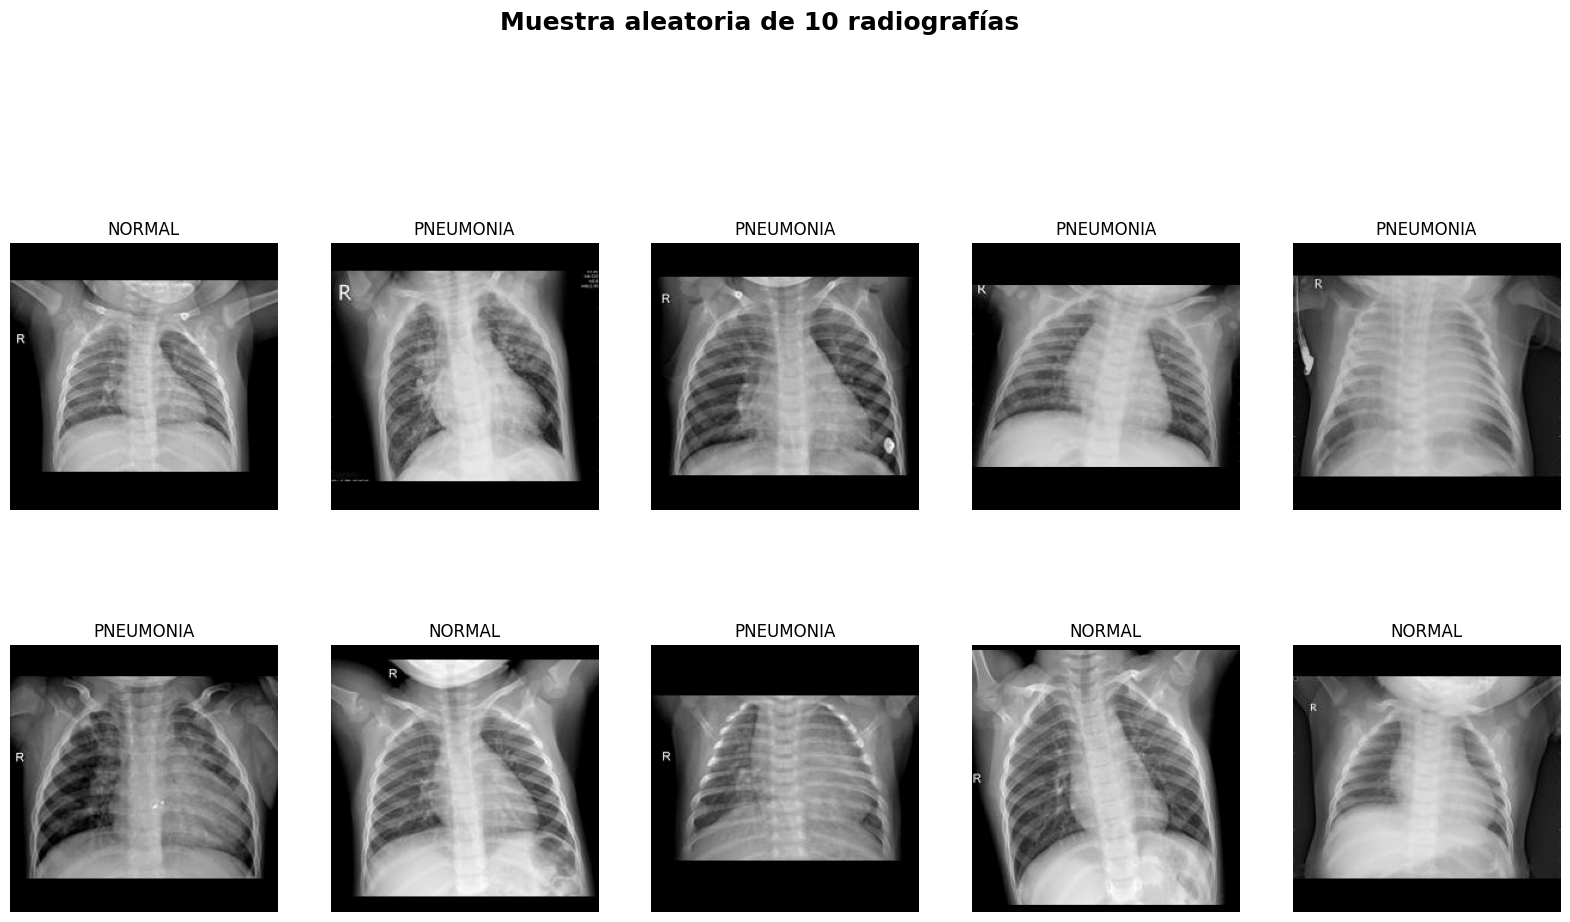

In [ ]:
# Daniela
# Toma un lote aleatorio de imágenes del conjunto de entrenamiento
for images, labels in train_ds_raw.shuffle(1000, seed=SEED).take(1):

    # Convierte los tensores de imágenes y etiquetas a arrays de NumPy
    # Esto permite manipularlos con matplotlib. El tipo uint8 es necesario
    # para que los valores de píxeles se interpreten correctamente (0–255).
    images_np = images.numpy().astype("uint8")
    labels_np = labels.numpy().astype("int")

    # Selecciona 10 índices aleatorios del lote sin repetir
    idx = np.random.choice(len(images_np), 10, replace=False)

    # Crea una figura grande para mostrar las imágenes
    plt.figure(figsize=(20, 20))

    # Itera sobre los 10 índices seleccionados
    for i, j in enumerate(idx):
        plt.subplot(4, 5, i + 1)  # Organiza en una cuadrícula de 4 filas x 5 columnas
        plt.imshow(images_np[j].squeeze(), cmap="gray")  # Muestra la imagen en escala de grises
        plt.title("NORMAL" if labels_np[j] == 0 else "PNEUMONIA")  # Título según la clase
        plt.axis("off")  # Oculta los ejes para una visualización más limpia

    # Título general de la figura
    plt.suptitle("Muestra aleatoria de 10 radiografías", fontsize=18, fontweight="bold")
    plt.show()  # Muestra la figura en pantalla


#ENTRENAMIENTO




##Aplicación de técnica de pesos.
 esta técnica asigna un peso mayor a las clases minoritarias y un peso menor a las clases mayoritarias. Esto obliga al modelo a prestar más atención a las clases que tienen menos ejemplos, evitando que simplemente aprenda a predecir la clase más frecuente



In [ ]:
#JUAN

#ENTRENAMIENTO DE CNN
IMG_SIZE = 224 # Definimos el tamaño de las imágenes de entrada (224x224 píxeles)
def build_cnn():
    # Entrada de la red: imágenes en escala de grises (1 canal)
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # Definición de un bloque convolucional
    def conv_block(x, f, p=0.0):
        x = layers.Conv2D(f, 3, padding="same", activation="relu",  #aplicacion de 3x3 kernel para analisis detallado de las imagenes
                          kernel_initializer="he_normal", # normalización de pesos con "he_normal"
                          kernel_regularizer=regularizers.l2(1e-5))(x) # Regularización L2 para evitar sobreajuste
        x = layers.BatchNormalization()(x)
        if p: x = layers.SpatialDropout2D(p)(x)
        x = layers.MaxPooling2D()(x)
        return x
    # Aplicamos los bloques convolucionales con diferentes cantidades de filtros
    x = conv_block(inp, 32) # Primer bloque con 32 filtros
    x = conv_block(x,   64) # Segundo bloque con 64 filtros
    x = conv_block(x,  128, p=0.1) # Tercer bloque con 128 filtros y dropout 0.1
    x = conv_block(x,  256, p=0.1) # Cuarto bloque con 256 filtros y dropout 0.1

    # Global Average Pooling: reduce cada mapa de características a un solo valor
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)  # Dropout del 40% para reducir sobreajuste

    # Capa totalmente conectada (densa) con 128 neuronas y activación ReLU
    x = layers.Dense(128, activation="relu",
                     kernel_initializer="he_normal",
                     kernel_regularizer=regularizers.l2(1e-5))(x)

    x = layers.Dropout(0.3)(x) # Dropout del 30% en la capa densa

    # Capa de salida con activación sigmoide para clasificación binaria (0 = normal, 1 = neumonía)
    out = layers.Dense(1, activation="sigmoid")(x)

    # Definimos el modelo final
    return models.Model(inp, out, name="PneumoniaCNN_Grayscale_v2")

###ENTRENAMIENTO SIN PESO VS ENTRENAMIENTO CON PESO

In [ ]:
#JUAN

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en el conjunto de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los pesos del modelo de la época con la mejor pérdida de validación
)

# Función para compilar el modelo
def compile_model(m):
    m.compile(
        optimizer=optimizers.Adam(1e-3), # Optimizador Adam con tasa de aprendizaje 0.001
        loss="binary_crossentropy", # Pérdida para clasificación binaria
        metrics=[
            "accuracy", # Métrica de precisión global
            metrics.AUC(name="auc"), # Área bajo la curva ROC
            metrics.AUC(name="pr_auc", curve="PR"), # Área bajo la curva de precisión-recall
            metrics.Precision(name="precision"), # Precisión (verdaderos positivos / todos los predichos como positivos)
            metrics.Recall(name="recall"), # Recall o sensibilidad (verdaderos positivos / todos los positivos reales)
        ],
    )

# Entrenamiento SIN class_weight
model_no_w = build_cnn() # Construimos el modelo CNN definido antes
compile_model(model_no_w) # Compilamos el modelo
print("Entrenando SIN class_weight...")

# Entrenamiento del modelo
history_no_w = model_no_w.fit(
    train_ds_prep, # Conjunto de entrenamiento
    validation_data=val_ds_prep, # Conjunto de validación
    epochs=50, # Número máximo de épocas
    verbose=1, # Muestra el progreso por consola
    callbacks=[early_stopping_callback] # Aplica el EarlyStopping
)

# Predicciones en TEST (sin pesos)
y_true, y_prob = [], [] # Listas para etiquetas

# Iteramos sobre lotes del conjunto de prueba
for Xb, yb in test_ds_prep:
    p = model_no_w.predict(Xb, verbose=0).ravel() # Predicciones de probabilidad
    y_prob.extend(p) # Predicciones de probabilidad
    y_true.extend(yb.numpy().astype(int)) # Guardamos etiquetas reales

y_true = np.array(y_true) # Convertimos a array
y_pred = (np.array(y_prob) >= 0.5).astype(int) # Clasificación final (umbral 0.5)

# Reporte de resultados
print("\n SIN class_weight")
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"]))

# Cálculo del AUC-ROC con las probabilidades
try:
    print("AUC (probabilidades):", roc_auc_score(y_true, y_prob))
except Exception as e:
    print("AUC no disponible:", e)

Entrenando SIN class_weight...
Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - accuracy: 0.8223 - auc: 0.8668 - loss: 0.4183 - pr_auc: 0.9485 - precision: 0.8820 - recall: 0.8763 - val_accuracy: 0.7570 - val_auc: 0.5000 - val_loss: 2.4057 - val_pr_auc: 0.7570 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9026 - auc: 0.9514 - loss: 0.2545 - pr_auc: 0.9806 - precision: 0.9370 - recall: 0.9314 - val_accuracy: 0.7570 - val_auc: 0.5000 - val_loss: 3.0222 - val_pr_auc: 0.7570 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9166 - auc: 0.9612 - loss: 0.2282 - pr_auc: 0.9841 - precision: 0.9470 - recall: 0.9403 - val_accuracy: 0.7570 - val_auc: 0.5132 - val_loss: 2.2145 - val_pr_auc: 0.7619 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9222 - auc: 0.9698 - loss: 0.2073 - pr_auc: 0.9891 - pr

In [ ]:
#JUAN


# === Cálculo de class_weight desde el dataset===
def count_from_ds(ds):
    # Función para contar cuántas muestras hay de cada clase en el dataset
    counts = {0: 0, 1: 0} # Diccionario para clases: 0 = NORMAL, 1 = PNEUMONIA
    for _, y in ds.unbatch(): # Recorremos el dataset desagrupado (unbatch quita los lotes)
        counts[int(y.numpy())] += 1 # Convertimos etiqueta a entero y sumamos al contador
    return counts

# Contamos las clases en el conjunto de entrenamiento crudo (sin preprocesar)
counts = count_from_ds(train_ds_raw)
print("Recuento de clases en train_ds_raw:", counts)

# Cálculo de los pesos de cada clase
total = counts[0] + counts[1] # Total de muestras
class_weight = {
    0: total / (2 * counts[0]), # Peso para la clase 0 (NORMAL)
    1: total / (2 * counts[1]), # Peso para la clase 1 (PNEUMONIA)
}
print("\nClass weights:", class_weight)

#  (C) Entrenamiento CON class_weight
model_w = build_cnn() # Construimos el modelo CNN
compile_model(model_w) # Lo compilamos con Adam y métricas
print("\nEntrenando CON class_weight...")

# Entrenamiento aplicando los class_weight calculados
history_w = model_w.fit(
    train_ds_prep, # Conjunto de entrenamiento preprocesado
    validation_data=val_ds_prep, # Conjunto de validación
    epochs=50, # Máximo 50 épocas
    class_weight=class_weight, # Ajuste de pesos según desbalance
    verbose=1, # Muestra progreso en consola
    callbacks=[early_stopping_callback] # Aplica EarlyStopping
)

# Predicciones en TEST (con pesos)
y_true_w, y_prob_w = [], []  # Etiquetas
for Xb, yb in test_ds_prep:
    p = model_w.predict(Xb, verbose=0).ravel() # Predicciones de probabilidad
    y_prob_w.extend(p) # Guardamos probabilidades
    y_true_w.extend(yb.numpy().astype(int)) # Guardamos etiquetas reales
# Convertimos listas a arrays de NumPy
y_true_w = np.array(y_true_w)
y_pred_w = (np.array(y_prob_w) >= 0.5).astype(int)

# Reporte de resultados
print("\n=== CON class_weight ===")
print(confusion_matrix(y_true_w, y_pred_w))
print(classification_report(y_true_w, y_pred_w, target_names=["NORMAL","PNEUMONIA"]))

# Cálculo de AUC-ROC con probabilidades
try:
    print("AUC (probabilidades):", roc_auc_score(y_true_w, y_prob_w))
except Exception as e:
    print("AUC no disponible:", e)


/tmp/ipython-input-3953355013.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts[int(y.numpy())] += 1 # Convertimos etiqueta a entero y sumamos al contador


Recuento de clases en train_ds_raw: {0: 1151, 1: 3283}

Class weights: {0: 1.9261511728931364, 1: 0.675296984465428}

Entrenando CON class_weight...
Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - accuracy: 0.8041 - auc: 0.8844 - loss: 0.4304 - pr_auc: 0.9511 - precision: 0.9304 - recall: 0.7955 - val_accuracy: 0.7570 - val_auc: 0.5000 - val_loss: 1.8168 - val_pr_auc: 0.7570 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.8801 - auc: 0.9532 - loss: 0.2835 - pr_auc: 0.9835 - precision: 0.9672 - recall: 0.8679 - val_accuracy: 0.7570 - val_auc: 0.5000 - val_loss: 2.3835 - val_pr_auc: 0.7570 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8864 - auc: 0.9603 - loss: 0.2645 - pr_auc: 0.9858 - precision: 0.9726 - recall: 0.8716 - val_accuracy: 0.7954 - val_auc: 0.9573 - val_loss: 0.5101 - val_pr_auc: 0.9825 - val_precision: 0.7872 - val_recall: 1.0000
Epoc

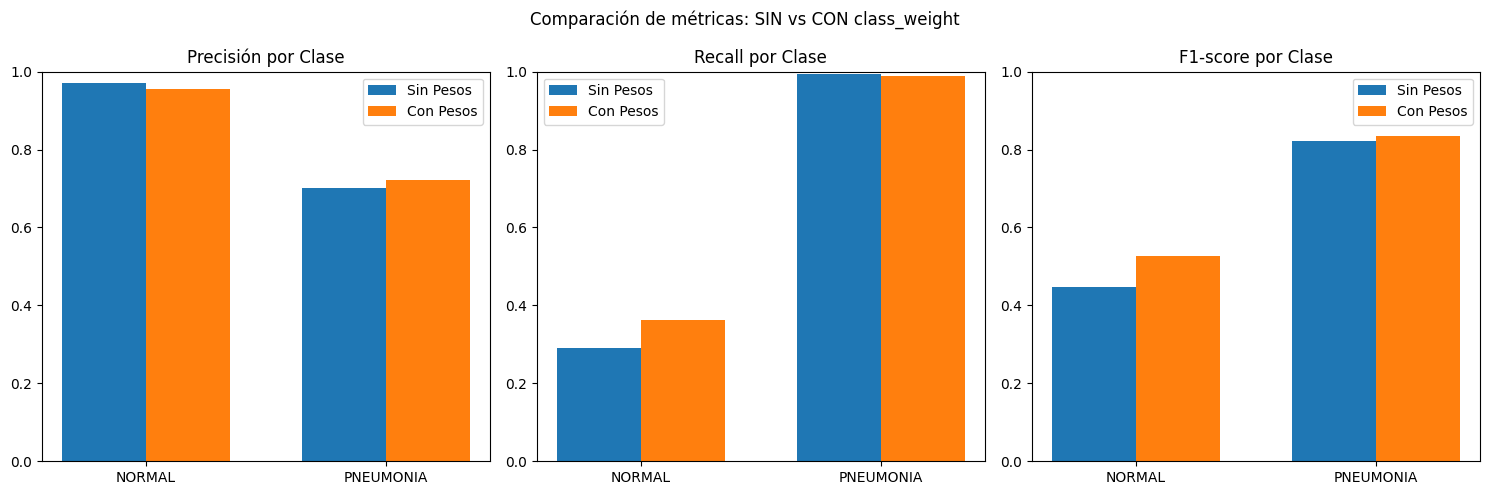

In [ ]:
#JUAN
#Gráfico comparativo (Precisión/Recall/F1 por clase)
prec_no, rec_no, f1_no, _ = precision_recall_fscore_support(y_true,   y_pred,   labels=[0,1])
prec_w,  rec_w,  f1_w,  _ = precision_recall_fscore_support(y_true_w, y_pred_w, labels=[0,1])

clases = ["NORMAL", "PNEUMONIA"]
x = np.arange(len(clases))
width = 0.35

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].bar(x - width/2, prec_no, width, label="Sin Pesos")
axs[0].bar(x + width/2, prec_w,  width, label="Con Pesos")
axs[0].set_title("Precisión por Clase"); axs[0].set_xticks(x); axs[0].set_xticklabels(clases); axs[0].set_ylim(0,1); axs[0].legend()

axs[1].bar(x - width/2, rec_no, width, label="Sin Pesos")
axs[1].bar(x + width/2, rec_w,  width, label="Con Pesos")
axs[1].set_title("Recall por Clase"); axs[1].set_xticks(x); axs[1].set_xticklabels(clases); axs[1].set_ylim(0,1); axs[1].legend()

axs[2].bar(x - width/2, f1_no, width, label="Sin Pesos")
axs[2].bar(x + width/2, f1_w,  width, label="Con Pesos")
axs[2].set_title("F1-score por Clase"); axs[2].set_xticks(x); axs[2].set_xticklabels(clases); axs[2].set_ylim(0,1); axs[2].legend()

plt.suptitle("Comparación de métricas: SIN vs CON class_weight")
plt.tight_layout()
plt.show()

###MATRIZ DE CONFUSIÓN WEIGHT VS NO WEIGHT

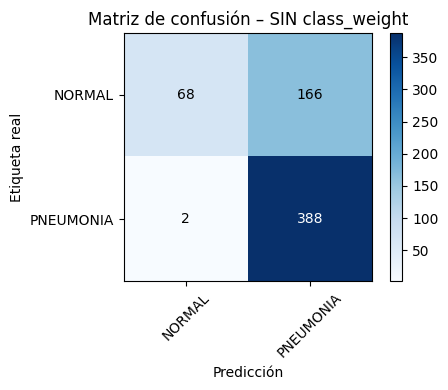

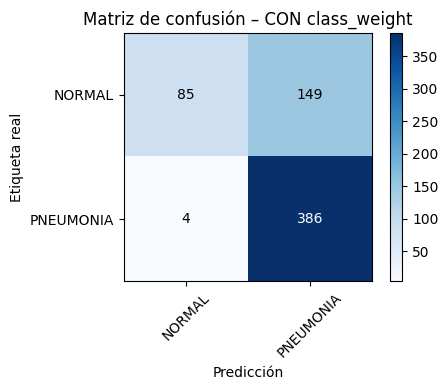

In [ ]:
#SARA
def plot_cm(cm, title):  # Función para graficar la matriz de confusión con título
    plt.figure(figsize=(5,4))  # Define el tamaño de la figura
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Muestra la matriz como imagen en escala de azules
    plt.title(title)  # Coloca el título
    plt.colorbar()  # Agrega la barra de colores a la derecha
    tick_marks = np.arange(2)  # Rango de índices (2 clases: NORMAL y PNEUMONIA)
    classes = ["NORMAL","PNEUMONIA"]  # Nombres de las clases
    plt.xticks(tick_marks, classes, rotation=45)  # Etiquetas del eje X con rotación
    plt.yticks(tick_marks, classes)  # Etiquetas del eje Y

    # Anotaciones en cada celda de la matriz
    thresh = cm.max() / 2.  # Umbral para decidir el color del texto
    for i in range(cm.shape[0]):  # Recorre filas
        for j in range(cm.shape[1]):  # Recorre columnas
            plt.text(j, i, format(cm[i, j], 'd'),  # Escribe el valor de la celda
                     ha="center", va="center",  # Centrado horizontal y vertical
                     color="white" if cm[i, j] > thresh else "black")  # Texto blanco si el valor es grande
    plt.ylabel('Etiqueta real')  # Nombre eje Y
    plt.xlabel('Predicción')  # Nombre eje X
    plt.tight_layout()  # Ajusta para que nada quede cortado
    plt.show()  # Muestra la figura

# CM sin pesos
cm_no = confusion_matrix(y_true, y_pred)  # Calcula matriz de confusión con predicciones normales
plot_cm(cm_no, "Matriz de confusión – SIN class_weight")  # Llama la función para graficarla

# CM con pesos
cm_w  = confusion_matrix(y_true_w, y_pred_w)  # Calcula matriz de confusión con predicciones con pesos
plot_cm(cm_w, "Matriz de confusión – CON class_weight")  # Llama la función para graficarla


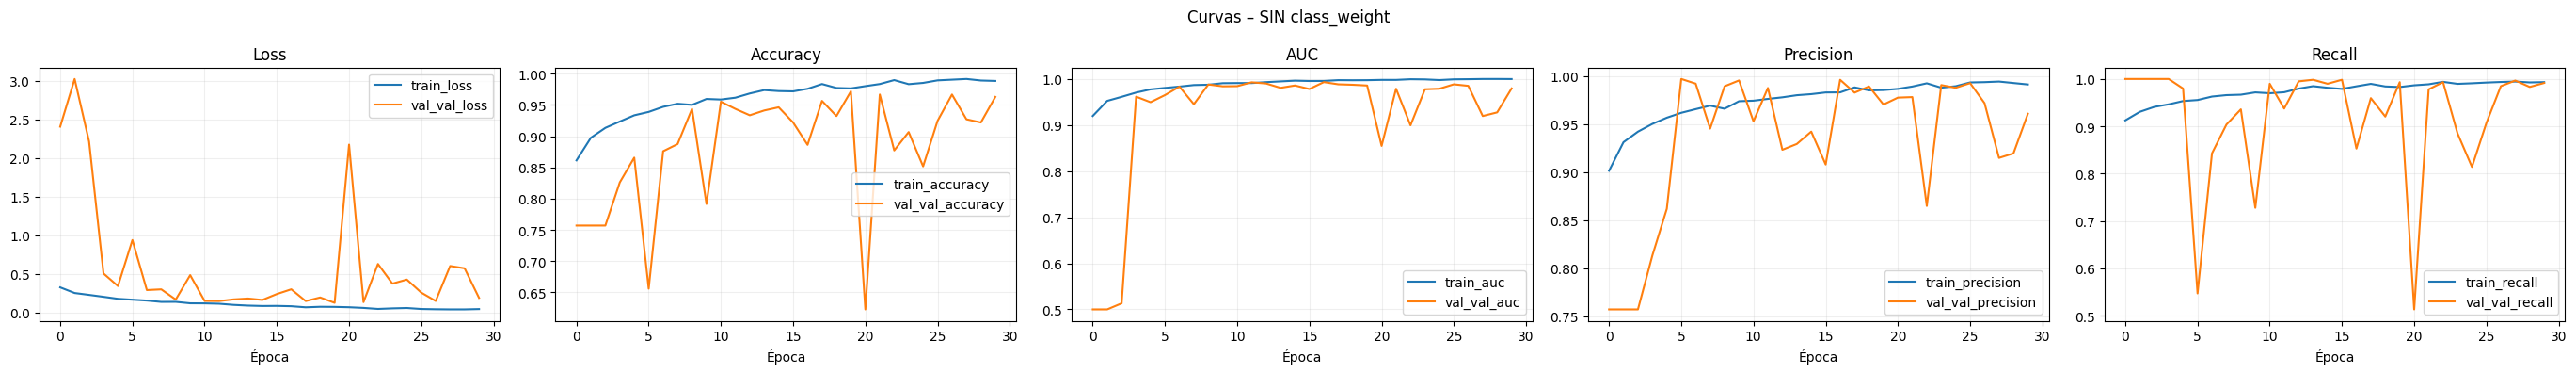

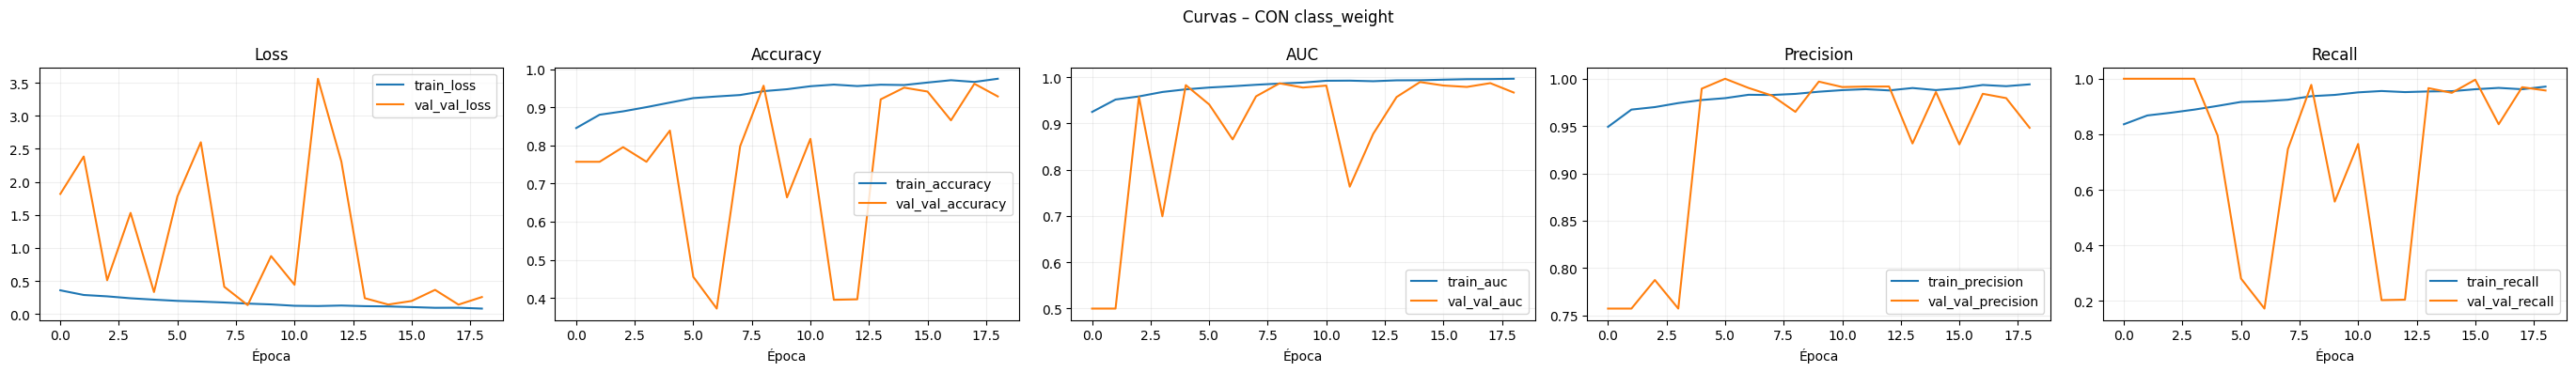

In [ ]:
# Sara

# ===== Curvas de aprendizaje =====
import matplotlib.pyplot as plt  # Librería para graficar

def plot_history(h, title="Historia de entrenamiento"):  # Función para graficar métricas de entrenamiento/validación
    if h is None:  # Si no se pasa un history válido
        print("No hay history para graficar.");  # Mensaje de aviso
        return
    hist = h.history  # Accede al diccionario de métricas que guarda Keras
    metrics_to_plot = [  # Lista de métricas que queremos graficar (train vs val)
        ("loss", "val_loss", "Loss"),  # Pérdida
        ("accuracy", "val_accuracy", "Accuracy"),  # Exactitud
        ("auc", "val_auc", "AUC"),  # Área bajo la curva ROC
        ("precision", "val_precision", "Precision"),  # Precisión
        ("recall", "val_recall", "Recall")  # Sensibilidad (recuperación de positivos)
    ]
    # Filtra solo las métricas que realmente existan en este entrenamiento
    metrics_to_plot = [(m, vm, lab) for (m, vm, lab) in metrics_to_plot if (m in hist and vm in hist)]
    n = len(metrics_to_plot)  # Número de métricas que sí se pueden graficar
    if n == 0:  # Si no hay ninguna métrica disponible
        print("No hay métricas para graficar en este history.")  # Mensaje
        return

    plt.figure(figsize=(5.5*n, 4))  # Define el tamaño total de la figura en base a cuántas métricas se grafican
    for i, (m, vm, lab) in enumerate(metrics_to_plot, 1):  # Itera sobre cada métrica
        plt.subplot(1, n, i)  # Crea un subgráfico en una fila, con tantas columnas como métricas
        plt.plot(hist[m], label=f"train_{m}")  # Dibuja la curva de entrenamiento
        plt.plot(hist[vm], label=f"val_{vm}")  # Dibuja la curva de validación
        plt.title(lab); plt.xlabel("Época")  # Título y eje X
        plt.legend(); plt.grid(alpha=0.2)  # Leyenda y grilla ligera
    plt.suptitle(title); plt.tight_layout(); plt.show()  # Título general, ajusta el layout y muestra la figura

# Graficar ambas historias si existen
try:
    plot_history(history_no_w, "Curvas – SIN class_weight")  # Intenta graficar el entrenamiento sin pesos
except NameError:
    print("history_no_w no existe en esta sesión.")  # Si no está definido, lo avisa

try:
    plot_history(history_w, "Curvas – CON class_weight")  # Intenta graficar el entrenamiento con pesos
except NameError:
    print("history_w no existe en esta sesión.")  # Si no está definido, lo avisa


##Análisis de las Curvas de Aprendizaje: Comparación SIN vs. CON class_weight

###Observaciones de la Gráfica SIN class_weight
El conjunto de curvas de aprendizaje sin pesos de clase revela un claro caso de sobreajuste (overfitting).

- Pérdida (Loss) y Precisión (Accuracy): Se observa una gran brecha entre las
curvas de entrenamiento y validación. La pérdida de entrenamiento disminuye consistentemente, mientras que la pérdida de validación se mantiene alta y volátil. De manera similar, la precisión de entrenamiento aumenta, pero la de validación se estanca o incluso cae en las últimas épocas. Esto indica que el modelo está memorizando el conjunto de entrenamiento, pero no logra generalizar a datos no vistos.

- Métricas Específicas (AUC, Precision, Recall): Las curvas de validación para estas métricas son significativamente más bajas que las de entrenamiento y muestran un comportamiento errático. La baja precisión y recall de validación sugieren que el modelo tiene dificultades para identificar correctamente la clase minoritaria (PNEUMONIA), lo cual es un problema común en conjuntos de datos desequilibrados.

- AUC (Area Under the Curve): mide la capacidad del modelo para diferenciar entre clases; cuanto más cercano a 1, mejor distingue positivos y negativos.

- Precision: de todos los casos que el modelo predijo como positivos, qué proporción realmente lo son.

- Recall: de todos los casos positivos reales, qué proporción detectó correctamente el modelo.

###Observaciones de la Gráfica CON class_weight
El conjunto de curvas de aprendizaje con pesos de clase demuestra que el problema de desequilibrio se ha mitigado, resultando en un modelo más robusto y generalizable.

- Pérdida (Loss) y Precisión (Accuracy): La brecha entre las curvas de entrenamiento y validación se reduce significóvamente. Aunque la precisión de entrenamiento podría ser un poco menor, las métricas de validación son más altas y estables. Esto muestra que el modelo ahora está aprendiendo patrones útiles en lugar de solo memorizar.

- Métricas Específicas (AUC, Precision, Recall): Las curvas de validación para estas métricas, especialmente Recall, son notablemente más altas y estables que las del modelo sin pesos. Esto confirma que el modelo ha mejorado su capacidad para identificar correctamente los casos de la clase minoritaria, que es el objetivo principal.

###Conclusión
El análisis de las gráficas confirma que el uso de class_weight fue una estrategia efectiva para abordar el desequilibrio de clases en los datos. El modelo entrenado con esta técnica generaliza mucho mejor y logra un rendimiento superior en la tarea crítica de identificar la neumonía en el conjunto de validación, lo que lo hace más adecuado para su uso en un escenario real.



---



##Entrenamiento con modelo preentrenado EfficientNetB0


In [ ]:

# ENTRENAMIENTO DE EfficientNetB0


# Callbacks unificados para optimizar PR-AUC, métrica clave en contextos clínicos con clases desbalanceadas
es = callbacks.EarlyStopping(
    monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True
)  # Detiene si no mejora el PR-AUC en 8 épocas
rlrop = callbacks.ReduceLROnPlateau(
    monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6
)  # Reduce LR si PR-AUC se estanca
ckpt = callbacks.ModelCheckpoint(
    "eff_b0_best.keras", monitor="val_pr_auc", mode="max", save_best_only=True
)  # Guarda el mejor modelo según PR-AUC

# Función para construir el modelo EfficientNetB0 con pesos ImageNet y capa superior personalizada
def build_efficientnet_b0(img_size=224, dropout=0.3):
    inp = layers.Input(shape=(img_size, img_size, 3), name="input_rgb")  # Entrada RGB
    base = keras.applications.EfficientNetB0(
        include_top=False, input_tensor=inp, weights="imagenet"
    )  # Cuerpo preentrenado sin capa final
    base.trainable = False  # Fase 1: se congela la base
    x = layers.GlobalAveragePooling2D(name="gap")(base.output)  # Pooling global
    x = layers.Dropout(dropout, name="dropout")(x)  # Regularización
    out = layers.Dense(1, activation="sigmoid", name="pred")(x)  # Clasificación binaria
    model = models.Model(inp, out, name="EffNetB0_RGB")
    return model, base

# Función para compilar el modelo con métricas relevantes para diagnóstico médico
def compile_eff(model, lr=1e-3):
    model.compile(
        optimizer=optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",  # Métrica general
            metrics.AUC(name="auc"),  # ROC-AUC
            metrics.AUC(name="pr_auc", curve="PR"),  # PR-AUC (prioritaria)
            metrics.Precision(name="precision"),  # Precisión
            metrics.Recall(name="recall"),  # Sensibilidad
        ],
    )


# FASE 1: ENTRENAMIENTO INICIAL


eff_model, eff_base = build_efficientnet_b0(IMG_SIZE, dropout=0.3)  # Construye modelo
compile_eff(eff_model, lr=1e-3)  # Compila con LR inicial

# Entrena solo la capa superior (base congelada), usando pesos balanceados por clase
hist_eff_frozen = eff_model.fit(
    train_ds_rgb, validation_data=val_ds_rgb,
    epochs=15, callbacks=[es, rlrop, ckpt],
    class_weight=class_weight, verbose=1
)


# FASE 2: FINE-TUNING


eff_base.trainable = True  # Descongela la base para ajuste fino

# Congela las primeras capas y permite entrenar las últimas ~50 (más especializadas)
for l in eff_base.layers[:-50]:
    l.trainable = False

compile_eff(eff_model, lr=1e-4)  # Recompila con LR más bajo para evitar sobreajuste

# Continúa el entrenamiento con fine-tuning
hist_eff_ft = eff_model.fit(
    train_ds_rgb, validation_data=val_ds_rgb,
    epochs=20, callbacks=[es, rlrop, ckpt],
    class_weight=class_weight, verbose=1
)

# EVALUACIÓN FINAL EN TEST


# Carga el mejor modelo guardado según PR-AUC
best_eff = keras.models.load_model("eff_b0_best.keras", compile=False)
compile_eff(best_eff, lr=1e-4)  # Recompila para evaluación

# Evalúa en el conjunto de prueba y muestra métricas
test_metrics = best_eff.evaluate(test_ds_rgb, verbose=0)
print(dict(zip(best_eff.metrics_names, test_metrics)))  # Diccionario de métricas finales


# PREPARACIÓN PARA INTERPRETABILIDAD Y DESPLIEGUE


# Obtiene la última capa convolucional para Grad-CAM
best_base = best_eff.get_layer("top_conv")

# Visualización con Grad-CAM (comentado, se activa según necesidad)
# show_prediction_with_cam(..., model=best_eff, owner_model=best_base, last_conv_name="top_conv")

# Guarda el modelo final para despliegue clínico o análisis posterior
best_eff.save("pneumonia_effnet.keras")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 298ms/step - accuracy: 0.7377 - auc: 0.8066 - loss: 0.5142 - pr_auc: 0.9138 - precision: 0.8866 - recall: 0.7419 - val_accuracy: 0.8708 - val_auc: 0.9720 - val_loss: 0.3267 - val_pr_auc: 0.9910 - val_precision: 0.9920 - val_recall: 0.8361 - learning_rate: 0.0010
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9108 - auc: 0.9711 - loss: 0.2417 - pr_auc: 0.9903 - precision: 0.9714 - recall: 0.9068 - val_accuracy: 0.8939 - val_auc: 0.9775 - val_loss: 0.2693 - val_pr_auc: 0.9926 - val_precision: 0.9904 - val_recall: 0.8682 - learning_rate: 0.0010
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9230 - auc: 0.9776 - loss: 0.2051 - pr_auc: 0.9925 - precision: 0.9747 - recall: 0.9204 - val_accuracy: 0.9092 - val_auc: 0.9805 - val_loss: 0.2302 - val_pr_auc: 0.9935 - val_precision: 0.9887 - val_recall: 0.8902 - learning_rate: 0.0010
Epoch 4/15
139/139 ━━━━━━━━━━━

In [ ]:
# Daniela
def plot_combined_history(h_cnn, h_effnet, title="Comparación de Curvas de Aprendizaje PESOS VS EfficientNetB0"):
    # Verifica que ambas historias de entrenamiento estén disponibles
    if h_cnn is None or h_effnet is None:
        print("No se pueden graficar ambas historias.")
        return

    # Extrae los diccionarios de métricas por época
    hist_cnn = h_cnn.history
    hist_effnet = h_effnet.history

    # Define las métricas a graficar
    metrics_to_plot = ["loss", "accuracy", "auc", "precision", "recall"]
    n = len(metrics_to_plot)  # Número de métricas

    # Crea una figura con subplots horizontales, uno por métrica
    plt.figure(figsize=(5.5 * n, 4))  # Ajusta el tamaño según el número de métricas

    for i, m in enumerate(metrics_to_plot, 1):
        plt.subplot(1, n, i)  # Subplot en la posición correspondiente

        # Graficación de la CNN (líneas punteadas)
        plt.plot(hist_cnn[m], label=f"CNN train_{m}", linestyle='--')
        plt.plot(hist_cnn[f"val_{m}"], label=f"CNN val_{m}", linestyle='--')

        # Graficación de EfficientNetB0 (líneas sólidas)
        plt.plot(hist_effnet[m], label=f"EffNet train_{m}")
        plt.plot(hist_effnet[f"val_{m}"], label=f"EffNet val_{m}")

        # Personalización del subplot
        plt.title(m.capitalize())  # Título con nombre de la métrica
        plt.xlabel("Época")  # Eje X: número de épocas
        plt.legend()  # Muestra leyenda
        plt.grid(alpha=0.2)  # Añade rejilla suave

    # Título general de la figura
    plt.suptitle(title)

    # Ajuste automático del layout para evitar solapamientos
    plt.tight_layout()

    # Muestra la figura
    plt.show()


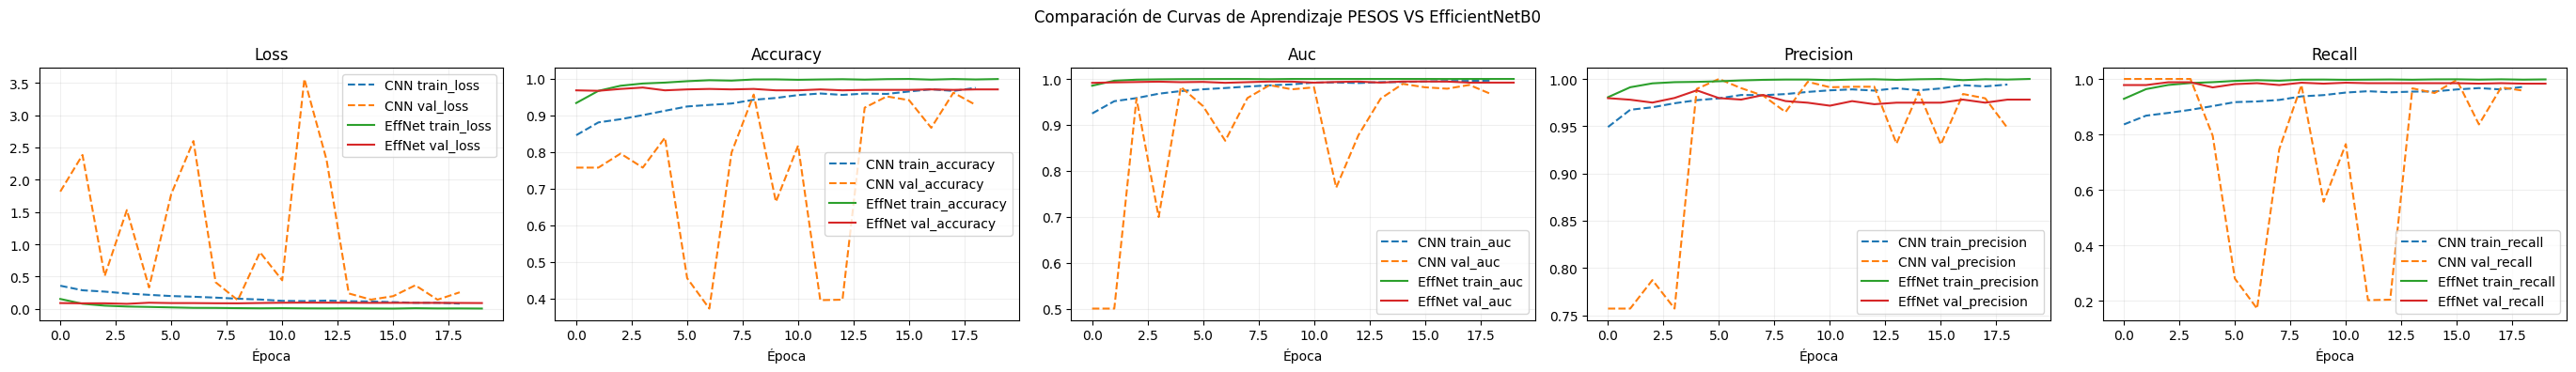

In [ ]:
plot_combined_history(history_w, hist_eff_ft)

Análisis de una imagen de neumonía


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


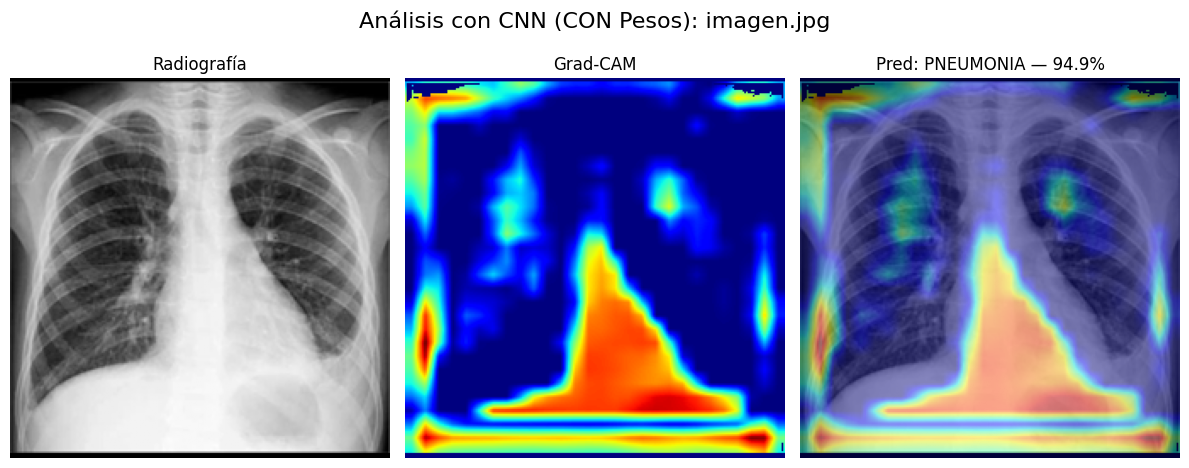

Diagnóstico de CNN (CON Pesos): PNEUMONIA — Probabilidad PNEUMONIA = 94.93% (umbral 50%)


/tmp/ipython-input-1380919753.py:161: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.datetime.utcnow().isoformat() + "Z",


✅ Assets guardados en: /content/pred_outputs/CNN_CON_Pesos


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_rgb']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


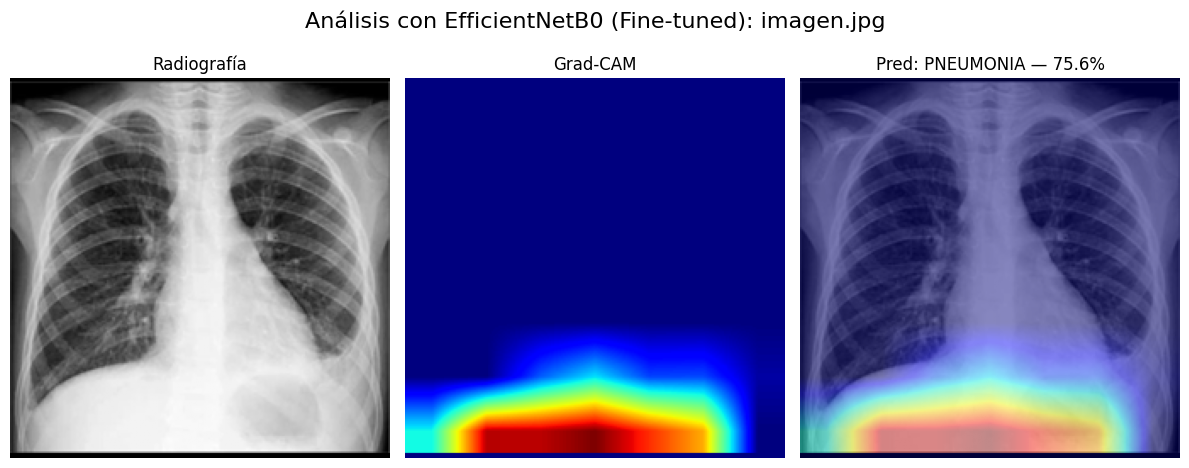

Diagnóstico de EfficientNetB0 (Fine-tuned): PNEUMONIA — Probabilidad PNEUMONIA = 75.56% (umbral 50%)
✅ Assets guardados en: /content/pred_outputs/EfficientNetB0_FT


In [ ]:
#SEBASTIAN


# 1) Resize letterbox (conserva aspecto, relleno negro)
# =========================
def resize_letterbox_pil(im, size=(224,224)):
    im = im.convert("L")  # gris
    w, h = im.size
    scale = min(size[0]/w, size[1]/h)
    nw, nh = max(1, int(w*scale)), max(1, int(h*scale))
    im_res = im.resize((nw, nh), Image.BICUBIC)
    canvas = Image.new("L", size, color=0)
    off_x, off_y = (size[0]-nw)//2, (size[1]-nh)//2
    canvas.paste(im_res, (off_x, off_y))
    return canvas

# =========================
# 2) Preprocesamiento (grises + 1/255) y ajuste de canales según modelo
# =========================
def load_xray_for_model(path, model, img_size=224):
    with Image.open(path) as im:
        im = resize_letterbox_pil(im, (img_size, img_size))
        arr = np.array(im, dtype=np.float32) / 255.0
    in_ch = model.input_shape[-1]
    if in_ch == 1:
        arr = arr[..., np.newaxis]             # (H,W,1)
    elif in_ch == 3:
        arr = np.stack([arr, arr, arr], axis=-1)  # (H,W,3)
    else:
        raise ValueError(f"Canales de entrada no soportados: {in_ch}")
    return arr, im  # im ya es 224x224 para visualizar

# =========================
# 3) Predicción con probabilidad (sigmoide = prob de clase PNEUMONIA)
# =========================
def predict_xray(path, model, threshold=0.5, img_size=224):
    arr, im_vis = load_xray_for_model(path, model, img_size)
    prob = float(model.predict(arr[np.newaxis, ...], verbose=0).ravel()[0])
    label = "PNEUMONIA" if prob >= threshold else "NORMAL"
    return label, prob, im_vis, arr

# =========================
# 4) Grad-CAM con soporte de submodelos (EfficientNet, etc.)
# =========================
def find_last_conv_and_owner(model):

    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name, model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.Model):  # submodelo
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name, layer
    raise ValueError("No se encontró capa Conv2D para Grad-CAM.")

def make_gradcam_heatmap_logits_owner(model, img_array,
                                      last_conv_name=None, owner_model=None,
                                      target="auto"):

    if last_conv_name is None or owner_model is None:
        last_conv_name, owner_model = find_last_conv_and_owner(model)

    conv_layer = owner_model.get_layer(last_conv_name)
    conv_output_tensor = conv_layer.output

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[conv_output_tensor, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, prob = grad_model(img_array[np.newaxis, ...], training=False)
        p = tf.clip_by_value(prob, 1e-7, 1. - 1e-7)
        logit = tf.math.log(p / (1. - p))  # logit de la clase positiva

        if target == "PNEUMONIA":
            loss = logit[:, 0]
        elif target == "NORMAL":
            loss = -logit[:, 0]
        else:  # auto -> explica la clase predicha
            loss = tf.where(prob[:, 0] >= 0.5, logit[:, 0], -logit[:, 0])

    grads   = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2))   # (B,C)
    cam     = tf.reduce_sum(weights[:, None, None, :] * conv_out, axis=-1)  # (B,Hc,Wc)
    cam     = tf.nn.relu(cam[0])

    # normaliza y reescala al tamaño de entrada
    cam = cam - tf.reduce_min(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., None], (img_array.shape[0], img_array.shape[1])).numpy().squeeze()
    return cam

def heatmap_remove_letterbox(heat, img_array):
    """Enmascara el padding negro del letterbox para que el heatmap no se pegue a los bordes."""
    mask = (img_array.sum(axis=-1) > 0)  # True donde hay imagen real
    heat = heat * mask
    hmax = heat.max()
    if hmax > 0:
        heat = heat / hmax
    return heat

# =========================
# 5) Visualización y (opcional) guardado de assets
# =========================
def show_prediction_with_cam(path, model, model_name,
                             threshold=0.5, alpha=0.45,
                             last_conv_name=None, owner_model=None,
                             target="auto", img_size=224,
                             save_dir=None):
    # Predicción
    label, prob, im_vis, arr = predict_xray(path, model, threshold=threshold, img_size=img_size)

    # Grad-CAM (con soporte de submodelos)
    heat = make_gradcam_heatmap_logits_owner(
        model, arr,
        last_conv_name=last_conv_name,
        owner_model=owner_model,
        target=target
    )
    heat = heatmap_remove_letterbox(heat, arr)

    # Visualización
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Análisis con {model_name}: {os.path.basename(path)}", fontsize=16)

    plt.subplot(1, 3, 1); plt.imshow(im_vis, cmap="gray"); plt.title("Radiografía"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(heat, cmap="jet");   plt.title("Grad-CAM");    plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(im_vis, cmap="gray"); plt.imshow(heat, cmap="jet", alpha=alpha)
    plt.title(f"Pred: {label} — {prob*100:.1f}%"); plt.axis("off")

    plt.tight_layout(); plt.show()
    print(f"Diagnóstico de {model_name}: {label} — Probabilidad PNEUMONIA = {prob*100:.2f}% (umbral {threshold*100:.0f}%)")

    # Guardado opcional para frontend
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        # imagen original 224x224
        path_img = os.path.join(save_dir, "image.png")
        im_vis.save(path_img)

        # heatmap
        path_heat = os.path.join(save_dir, "heatmap.png")
        plt.figure(figsize=(4,4)); plt.imshow(heat, cmap="jet"); plt.axis("off")
        plt.tight_layout(); plt.savefig(path_heat, bbox_inches="tight", pad_inches=0); plt.close()

        # overlay
        path_overlay = os.path.join(save_dir, "overlay.png")
        plt.figure(figsize=(4,4)); plt.imshow(im_vis, cmap="gray")
        plt.imshow(heat, cmap="jet", alpha=alpha); plt.axis("off")
        plt.tight_layout(); plt.savefig(path_overlay, bbox_inches="tight", pad_inches=0); plt.close()

        # JSON con resultados
        meta = {
            "input_image": os.path.basename(path),
            "model_name": getattr(model, "name", model_name),
            "predicted_label": label,
            "probability_pneumonia": float(prob),
            "threshold": float(threshold),
            "generated_at": datetime.datetime.utcnow().isoformat() + "Z",
            "assets": {
                "image": "image.png",
                "heatmap": "heatmap.png",
                "overlay": "overlay.png"
            }
        }
        with open(os.path.join(save_dir, "result.json"), "w") as f:
            json.dump(meta, f, indent=2)
        print(f"✅ Assets guardados en: {save_dir}")

# =========================
# 6) Ejemplos de uso
# =========================
imagen_a_diagnosticar = "/content/imagen.jpg"

print("=====================================================")
print("Análisis de una imagen de neumonía")
print("=====================================================")

# (A) CNN (con class_weight) – no necesita owner_model ni last_conv_name
try:
    show_prediction_with_cam(
        imagen_a_diagnosticar,
        model=model_w,
        model_name="CNN (CON Pesos)",
        threshold=0.5,
        alpha=0.45,
        last_conv_name=None,   # auto
        owner_model=None,      # auto (no hay submodelo)
        target="auto",
        img_size=224,
        save_dir="/content/pred_outputs/CNN_CON_Pesos"   # <- quita o cambia si no quieres guardar
    )
except NameError:
    print("model_w no está definido en esta sesión.")

# (B) EfficientNetB0 (fine-tuned) – la última conv suele ser 'top_conv' dentro de eff_base
try:
    show_prediction_with_cam(
        imagen_a_diagnosticar,
        model=eff_model,
        model_name="EfficientNetB0 (Fine-tuned)",
        threshold=0.5,
        alpha=0.45,
        last_conv_name="top_conv",  # confirma con: for l in eff_base.layers: print(l.name)
        owner_model=eff_base,       # IMPORTANTE: la capa pertenece al submodelo base
        target="auto",
        img_size=224,
        save_dir="/content/pred_outputs/EfficientNetB0_FT"
    )
except NameError:
    print("eff_model / eff_base no están definidos en esta sesión.")

In [ ]:
#descarga del modelo
eff_model.save("pneumonia_effnet.keras")